<h1>Experiments with Gaussian + Linear fits to spectra</h1>

In [1]:
from __future__ import print_function

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
# constants for all plots
x_label = '$\lambda$($\mu$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
plot_axis = [0.9, 2.4, 2.8e-15, 4.e-15]

<h3>Get raw data</h3>

In [2]:
data = np.genfromtxt("data/example_spec_ipac.txt")
wave = data[:,0]
flux = data[:,1]

<h3>Plot entire raw data</h3>

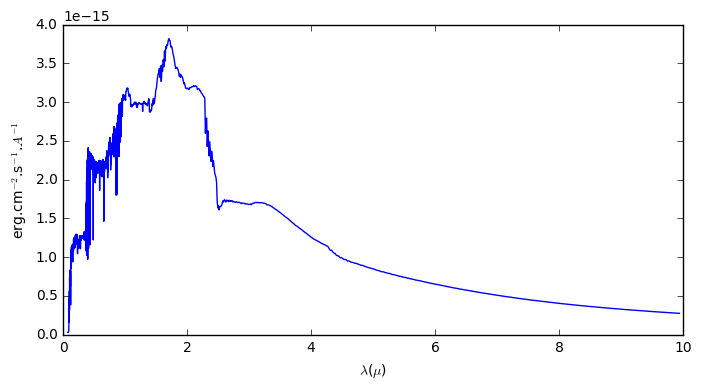

In [3]:
plt.gcf().set_size_inches(8.,4.)
plt.plot(wave, flux)
plt.xlabel(x_label)
plt.ylabel(y_label)

<h3>Extract region of interest </h3>

To repeat data in github issue #145

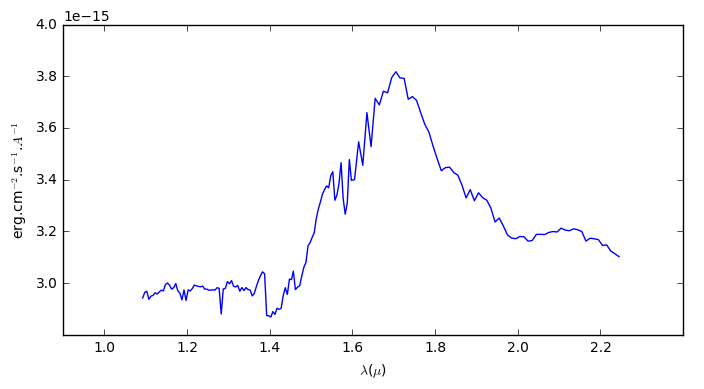

In [4]:
indices = (wave > 1.09) & (wave < 2.25) 
w = wave[indices]
f = flux[indices]
plt.gcf().set_size_inches(8.,4.)
plt.axis(plot_axis)
plt.plot(w, f)
plt.xlabel(x_label)
plt.ylabel(y_label)

<h3>Fit Gaussian + Linear using astropy </h3>

RMS =  7.74629939255e-16


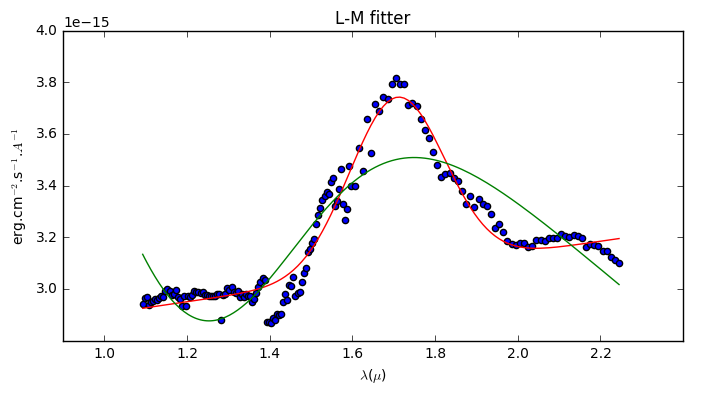

In [5]:
from astropy.modeling import models, fitting

fitter = fitting.LevMarLSQFitter()

# with specviz initialization - RED plot
centroid = np.sum(w * f) / np.sum(f)
dw = w - np.mean(w)
width = np.sqrt(np.sum((dw * dw) * f) / np.sum(f))
sum_f = np.sum(f - np.min(f))
height = sum_f / (width * np.sqrt(2 * np.pi) )
gaussian_i = models.Gaussian1D(amplitude=height, mean=centroid, stddev=width)

f_mean = np.mean(f)
linear_i = models.Linear1D(slope=0.0, intercept=f_mean)

model_i = gaussian_i + linear_i
fm_i = fitter(model_i, w, f, maxiter=2000)

# with astropy defaults - GREEN plot
model = models.Gaussian1D() + models.Linear1D()
fm = fitter(model, w, f, maxiter=2000)

plt.gcf().set_size_inches(8.,4.)
plt.axis(plot_axis)
plt.scatter(w, f)
plt.plot(w, fm_i(w), color='red')
plt.plot(w, fm(w), color='green')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("L-M fitter")

rms = np.sqrt(np.sum((f - fm_i(w))**2))
print("RMS = ", rms)

L-M only works in this case with maxiter=2000. With the default value (100) it doesn't converge. Specviz has it hardcoded to 2000 right now.

<h3>Repeat with Simplex and SLSQP fitter </h3>

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 817
         Function evaluations: 1326
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 950
         Function evaluations: 1624
RMS =  7.74629939005e-16


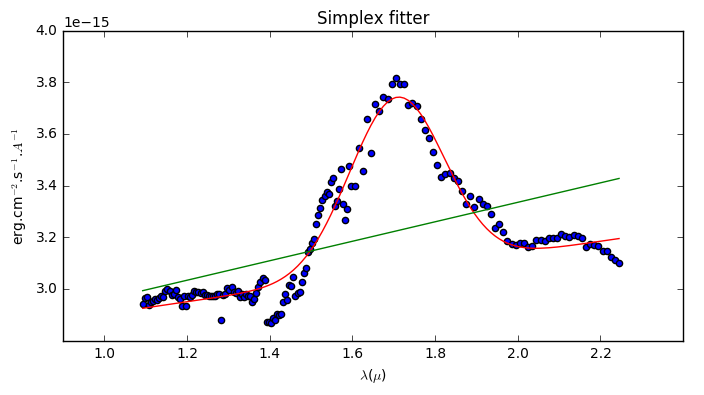

In [6]:
from astropy.modeling import models, fitting

fitter = fitting.SimplexLSQFitter()

# with specviz initialization - RED plot
fm_i = fitter(model_i, w, f, maxiter=10000)

# with astropy defaults - GREEN plot
fm = fitter(model, w, f, maxiter=10000)

plt.gcf().set_size_inches(8.,4.)
plt.axis(plot_axis)
plt.scatter(w, f)
plt.plot(w, fm_i(w), color='red')
plt.plot(w, fm(w), color='green')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("Simplex fitter")

rms = np.sqrt(np.sum((f - fm_i(w))**2))
print("RMS = ", rms)

Simplex must be iterated much further than L-M to reach convergency. With the specviz hardcoded value of maxiter=2000 it fails to reach convergency. It seems to be more sensitive to intial values than L-M.

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.38866676278e-25
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.44838126633e-08
            Iterations: 25
            Function evaluations: 183
            Gradient evaluations: 25
RMS =  5.82122561217e-13


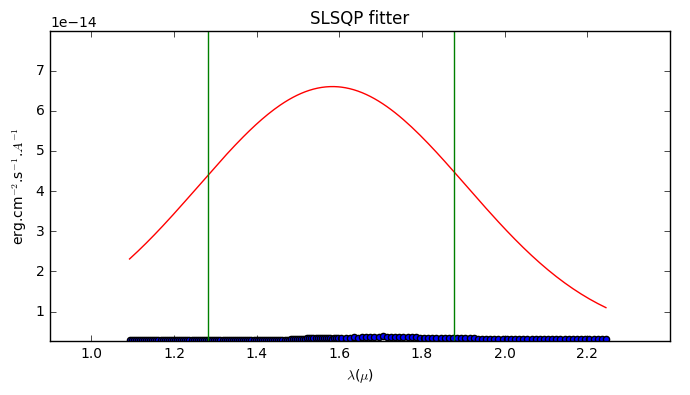

In [10]:
from astropy.modeling import models, fitting

fitter = fitting.SLSQPLSQFitter()

# with specviz initialization - RED plot
fm_i = fitter(model_i, w, f, maxiter=10000)

# with astropy defaults - GREEN plot
fm = fitter(model, w, f, maxiter=10000)

plt.gcf().set_size_inches(8.,4.)
#plt.axis(plot_axis)
plt.axis([0.9, 2.4, 2.8e-15, 8.e-14])
plt.scatter(w, f)
plt.plot(w, fm_i(w), color='red')
plt.plot(w, fm(w), color='green')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("SLSQP fitter")

rms = np.sqrt(np.sum((f - fm_i(w))**2))
print("RMS = ", rms)

It looks like the SLSQP fitter didn't do anything, because the solution (with specviz's initialization, red curve) is identical to the initial model. Specviz's initial model for the Gaussian component is quite off in height and width because we don't have a real gaussian + linear model, so what it does is to separately initialize the gaussian amd the linear components. Much better intialization would come from a Gauss+linear component.

In [ ]:
# WORK IN PROGRESS: attempting a simultaneous initialization of Gauss+linear to see how SLSQP performs

# retrieve 5% of data at each extreme of the wavelength range
l = len(w) / 20
w1 = w[0:l]




f_mean = np.mean(f)
linear_e = models.Linear1D(slope=0.0, intercept=f_mean)

centroid = np.sum(w * f) / np.sum(f)
dw = w - np.mean(w)
width = np.sqrt(np.sum((dw * dw) * f) / np.sum(f))
sum_f = np.sum(f - np.min(f))
height = sum_f / (width * np.sqrt(2 * np.pi) )
gaussian_e = models.Gaussian1D(amplitude=height, mean=centroid, stddev=width)

model_e = gaussian_e + linear_e

<h3>Repeat with optimize.curve_fit fitter </h3>

This seems to be the same solution given by astropy L-M: RMS is identical to 8 decimal places.

RMS =  7.7462993903e-16


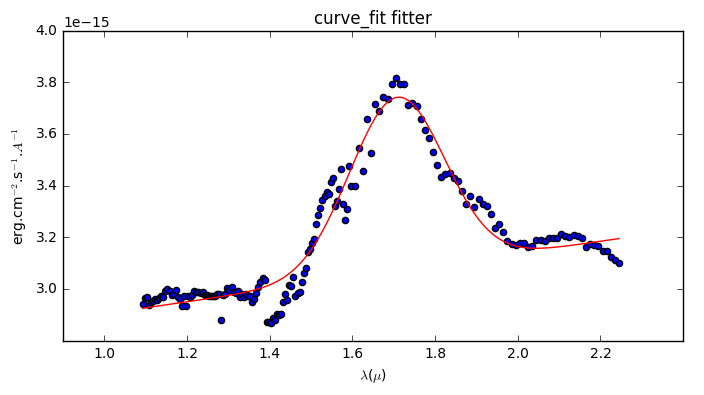

In [8]:
from scipy.optimize import curve_fit

def func(x, a, x0, sigma, slope, intercept):
    return (models.Gaussian1D(amplitude=a, mean=x0, stddev=sigma) + \
            models.Linear1D(slope=slope, intercept=intercept))(x)

popt, pcov = curve_fit(func, w, f)

plt.gcf().set_size_inches(8.,4.)
plt.axis(plot_axis)
plt.scatter(w, f)
plt.plot(w, func(w, popt[0], popt[1], popt[2], popt[3], popt[4]), color='red')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("curve_fit fitter")

rms = np.sqrt(np.sum((f - func(w, popt[0], popt[1], popt[2], popt[3], popt[4]))**2))
print("RMS = ", rms)

<h3>Repeat with Model from lmfit </h3>

[[Model]]
    (Model(gaussian) + Model(linear))
[[Fit Statistics]]
    # function evals   = 330
    # data points      = 167
    # variables        = 5
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -12465.950
    Bayesian info crit = -12450.360
[[Variables]]
    amp:     6.7287e-16 +/- 1.70e-17 (2.52%) (init= 6.286097e-14)
    cen:     1.70782594 +/- 0.003091 (0.18%) (init= 1.583442)
    wid:     0.11500177 +/- 0.003373 (2.93%) (init= 0.3239222)
    slope:   2.3416e-16 +/- 1.57e-17 (6.69%) (init= 0)
    inter:   2.6689e-15 +/- 2.42e-17 (0.91%) (init= 3.17312e-15)
[[Correlations]] (unreported correlations are <  0.100)
    C(slope, inter)              = -0.962 
    C(amp, wid)                  = -0.323 
    C(cen, slope)                = -0.301 
    C(cen, inter)                =  0.284 
    C(cen, wid)                  =  0.254 
    C(wid, slope)                = -0.208 
    C(amp, slope)                = -0.166 

RMS =  7.74629939577e-16


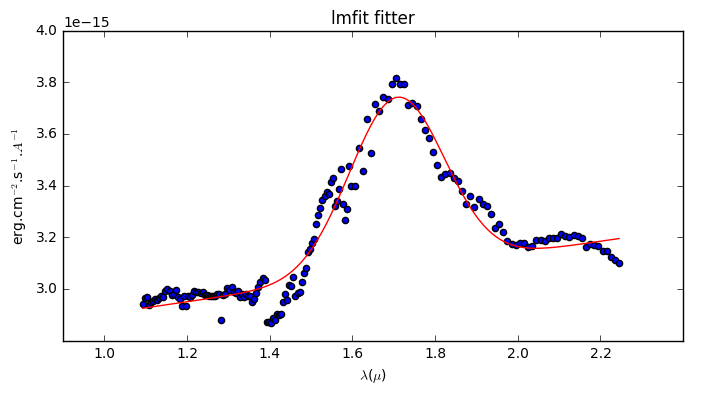

In [9]:
from lmfit import Model

def gaussian(x, amp, cen, wid):
    return models.Gaussian1D(amplitude=amp, mean=cen, stddev=wid)(x)

def linear(x, slope, inter):
    return models.Linear1D(slope=slope, intercept=inter)(x)

mod_i = Model(gaussian) + Model(linear)
pars_i  = mod_i.make_params(amp=height, cen=centroid, wid=width, slope=0.0, inter=f_mean)
fm_i = mod_i.fit(f, pars_i, x=w)

# lmfit doesn't support parameter default values

plt.gcf().set_size_inches(8.,4.)
plt.axis(plot_axis)
plt.scatter(w, f)
plt.plot(w, fm_i.best_fit, color='red')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("lmfit fitter")

print(fm_i.fit_report())

rms = np.sqrt(np.sum((f - fm_i.best_fit)**2))
print("RMS = ", rms)

Again, identical with astropy L-M.